# HW5 DATASCI W261: Machine Learning at Scale 

* **Name:**  Megan Jasek
* **Email:**  meganjasek@ischool.berkeley.edu
* **Class Name:**  W261-2
* **Week Number:**  5
* **Date:**  6/17/16

## HW 5.0
- What is a data warehouse? What is a Star schema? When is it used?

A data warehouse is a very large repository for data.  It can include many types of data like sales transactions or product inventories.  It can store relational (structured) data but more and more they are used to store unstructured data like tweets or semi-structured data like log files.  A data warehouse creates a base for data analysis activities like business intelligence and data mining.

The Star schema is a type of database schema.  It is made up of one or more fact tables referencing one or more dimension tables.  A fact table holds measurable quantitative information and a dimension table holds descriptive attributes related to the fact data.  It is used in relational databases to organize information.


## HW 5.1
- In the database world What is 3NF? Does machine learning use data in 3NF? If so why? 

The process of normalizing a database is the process of breaking down the data into smaller tables and linking them by keys.  The way in which you break down the data is such that no data is duplicated in the tables except for any information needed for linking the tables.  When data is not duplicated it saves space and allows for easier updates as the data only needs to be updated in one place.  3NF is a type of database normalization that reduces the duplication of data and ensures referential integrity.

Machine learning does not usually use data in 3NF form.

- In what form does ML consume data?  

Machine learning consumes data in denormalized form.  This is because with machine learning, the algorithms usually need all of the data fields together as a set of features.  If many of the features that are desired are stored in different tables of the database, these tables would need to be joined together before the machine learning algorithm could have all of the features in one place.

- Why would one use log files that are denormalized?  

One would use log files that are denormalized in order to feed the features directly into a machine learning model without having to go through a process of joining additional features in to the log files.

## HW 5.2
Using MRJob, implement a hashside join (memory-backed map-side) for left, right and inner joins. Run your code on the  data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.)

Justify which table you chose as the Left table in this hashside join.

**ANSWER:** There are 2 tables in this problem.  The first one is labeled 'PageID-URL' and it contains Page ID's and the URL's that the id's are associated with.  It contains about 590 records.  The second one is labeled 'PageID-VisitorID' and it contains Page ID's associated with Visitor ID's.  It contains about 130,000 records.  The smaller table (PageID-URL) was chosen to be on the left because when doing the left join there needs to be some way to mark which elements in the PageID-URL are not contained in the PageID-VisitorID table.  Doing this marking will take additional time and space that is proportional to the size of the left table.  In order to minimize time and space, the smaller table was chosen to be on the left.

Please report the number of rows resulting from:

- (1) Left joining Table Left with Table Right
- (2) Right joining Table Left with Table Right
- (3) Inner joining Table Left with Table Right

**ANSWER:**

| Join Type | # of Rows |
| - | - |
| Left | 98,663 |
| Right | 98,654 |
| Inner | 98,654 |  

Since the number of rows for the inner and right joins are the same, this means that there are not any entries in the PageID-VisitorID table that did not have PageID's in the PageID-URL table.

Since the number of rows for the left join is greater than the inner join, this means that there were 9 (98,663 - 98,654) rows in the PageID-URL table that did not have PageID's in the PageID-VisitorID table.

**Algorithm for hashside join** from Data-Intensive Text Processing with MapReduce by Jimmy Lin and Chris Dyer, section 3.5.3, page 67:  
1. Load the smaller dataset into memory in every mapper, populating an associative array to facilitate random access to tuples based on the join key. The mapper initialization API hook (see Section 3.1.1) can be used for this purpose.
2. Mappers are then applied to the other (larger) dataset, and for each input key-value pair, the mapper probes the in-memory dataset to see if there is a tuple with the same join key.
3. If there is, the join is performed.

### HW5.2 (1) Left joining Table Left with Table Right

In [10]:
%%writefile MemJoinLeft.py
from mrjob.job import MRJob
from mrjob.step import MRStep
 
# This class performs left join on the 2 datasets in the input file.
# The left table is Page ID's and URL's.  The right table is Page_ID's and Visitor ID's.
# It will output all rows from the left table, with the matching rows (matching Page ID's)
# in the right table. The output is NULL or blank on the right side when there is no match.
# The output is of the form URL, Page ID, Visitor ID
class MRMemJoinLeft(MRJob):
    # Initialize a dictionary to store the smaller dataset that will be held in memory.
    vroots = {}
    # Initialize a dictionary to keep track of the vroots (page_id's) that did not exist
    # in the right table.
    vroots_not_used = {}
    
    def mapper_memjoin_init(self):
        # Read the data from the filename and store it in the self.vroots dictionary.  This
        # stores the base URL and the vroot labels for each vroot.  For each vroot
        # in the file, store an empty entry for the vroot in the self.vroots_not_used dictionary
        filename = 'anonymous-msweb_converted.data'
        with open(filename, 'r') as f:
            base_url = ""
            for line in f.readlines():
                record = line.strip().split(',')
                if record[0] == 'I':
                    base_url = record[2].strip('"')
                elif record[0] == 'A':
                    page_id = record[1]
                    vroot = record[4].strip('"')
                    self.vroots[page_id] = base_url + vroot
                    self.vroots_not_used[page_id] = ''

    def mapper_memjoin(self, _, line):
        # read the next line from the file and only if it is a visitor record, denoted by
        # 'V', and only if the page_id is in the vroots dictionary, output the URL, Page ID
        # and Visitor ID.  Delete the page_id from the self.vroots_not_used dictionary
        # to indicate that this page_id has been output already.
        record = line.strip().split(',')
        if record[0] == 'V':
            page_id = record[1]
            visitor_id = record[4]
            page_visitor_pair = ('Page ID: %s, Visitor ID: %s' % (page_id, visitor_id))
            if page_id in self.vroots:
                if page_id in self.vroots_not_used:
                    del self.vroots_not_used[page_id]
                yield 'URL: ' + self.vroots[page_id], page_visitor_pair

    def mapper_memjoin_final(self):
        # To complete the left join, for any vroots still left in the self.vroots_not_used
        # dictionary, print them out with a None for the right side.
        for page_id in self.vroots_not_used:
            yield 'URL: ' + self.vroots[page_id], None
    
    # Create the steps for this job.  No reducer is required.
    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.maps': '1'
        }
        return[
            MRStep(jobconf=JOBCONF_STEP,
                   mapper_init=self.mapper_memjoin_init, 
                   mapper=self.mapper_memjoin,
                   mapper_final=self.mapper_memjoin_final)
        ]

if __name__ == '__main__':
    MRMemJoinLeft.run()

Overwriting MemJoinLeft.py


In [12]:
# Test this job with a smaller dataset
#!python MemJoinLeft.py anonymous-msweb_converted_small.data --file=anonymous-msweb_converted_small.data
# Run the job on the full dataset
!python MemJoinLeft.py anonymous-msweb_converted.data --file=anonymous-msweb_converted.data --output-dir=output/leftjoin --no-output
########### HW4.2 OUTPUT:  Number of Rows from Left Join ######
!wc -l output/leftjoin/part-00000

98663 output/leftjoin/part-00000


In [24]:
import MemJoinLeft
reload(MemJoinLeft)

TEST_FILE = False
#mr_job = MemJoinLeft.MRMemJoinLeft(args=['anonymous-msweb_converted_small.data','--file=anonymous-msweb_converted_small.data'])
mr_job = MemJoinLeft.MRMemJoinLeft(args=['anonymous-msweb_converted.data','--file=anonymous-msweb_converted.data'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    # stream_output: get access of the output 
    for line in runner.stream_output():
        if TEST_FILE:
            key,value =  mr_job.parse_output_line(line)
            if value == None:
                print key
            else:
                print key + ', ' + value
        count = count + 1
print "\n"
print "There are %s records" %count



There are 98663 records


### HW5.2 (2) Right joining Table Left with Table Right

In [14]:
%%writefile MemJoinRight.py
from mrjob.job import MRJob
from mrjob.step import MRStep

# This class performs right join on the 2 datasets in the input file.
# The left table is Page ID's and URL's.  The right table is Page_ID's and Visitor ID's.
# It will output all rows from the right table, with the matching rows (matching Page ID's)
# in the left table. The output is NULL or blank on the left side when there is no match.
# The output is of the form URL, Page ID, Visitor ID
class MRMemJoinRight(MRJob):
    # Create a dictionary to store the smaller dataset that will be held in memory.
    vroots = {}
    
    def mapper_memjoin_init(self):
        # Read the data from the filename and store it in the self.vroots dictionary.  This
        # stores the base URL and the vroot labels for each vroot. 
        filename = 'anonymous-msweb_converted.data'
        with open(filename, 'r') as f:
            base_url = ""
            for line in f.readlines():
                record = line.strip().split(',')
                if record[0] == 'I':
                    base_url = record[2].strip('"')
                elif record[0] == 'A':
                    page_id = record[1]
                    vroot = record[4].strip('"')
                    self.vroots[page_id] = base_url + vroot

    def mapper_memjoin(self, _, line):
        # read the next line from the file examine each line that starts with a 'V'.
        # Yield each of these lines.  If there is no url for one of the lines in the 
        # file, then output it with a url of 'None'.
        record = line.strip().split(',')
        if record[0] == 'V':
            page_id = record[1]
            visitor_id = record[4]
            page_visitor_pair = ('Page ID: %s, Visitor ID: %s' % (page_id, visitor_id))
            url = 'None'
            if page_id in self.vroots:
                url = self.vroots[page_id]
            yield 'URL: ' + url, page_visitor_pair
    
    # Create the steps for this job.  No reducer is required.
    def steps(self):
        return[
            MRStep(mapper_init=self.mapper_memjoin_init, 
                   mapper=self.mapper_memjoin)
        ]

if __name__ == '__main__':
    MRMemJoinRight.run()

Overwriting MemJoinRight.py


In [17]:
# Test this job on a smaller dataset
#!python MemJoinRight.py anonymous-msweb_converted_small.data --file=anonymous-msweb_converted_small.data
# Run this job on the full dataset
!python MemJoinRight.py anonymous-msweb_converted.data --file=anonymous-msweb_converted.data --output-dir=output/rightjoin --no-output
########### HW4.2 OUTPUT:  Number of Rows from Right Join ######
!wc -l output/rightjoin/part-00000
!wc -l output/rightjoin/part-00001
print(49062+49592)

49062 output/rightjoin/part-00000
49592 output/rightjoin/part-00001
98654


In [25]:
import MemJoinRight
reload(MemJoinRight)

TEST_FILE = False
#mr_job = MemJoinRight.MRMemJoinRight(args=['anonymous-msweb_converted_small.data','--file=anonymous-msweb_converted_small.data'])
mr_job = MemJoinRight.MRMemJoinRight(args=['anonymous-msweb_converted.data','--file=anonymous-msweb_converted.data'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    # stream_output: get access of the output 
    for line in runner.stream_output():
        if TEST_FILE:
            key,value =  mr_job.parse_output_line(line)
            print key + ', ' + value
        count = count + 1
print "\n"
print "There are %s records" %count



There are 98654 records


### HW5.2 (3) Inner joining Table Left with Table Right

In [19]:
%%writefile MemJoinInner.py
from mrjob.job import MRJob
from mrjob.step import MRStep
 
# This class performs an inner join on the 2 datasets in the input file.
# The left table is Page ID's and URL's.  The right table is Page_ID's and Visitor ID's.
# It will only output rows where the Page ID exists in both tables.  The output is 
# of the form URL, Page ID, Visitor ID
class MRMemJoinInner(MRJob):
    # Create a dictionary to store the smaller dataset that will be held in memory.
    vroots = {}
    
    def mapper_memjoin_init(self):
        # Read the data from the filename and store it in the self.vroots dictionary.  This
        # stores the base URL and the vroot labels for each vroot. 
        filename = 'anonymous-msweb_converted.data'
        with open(filename, 'r') as f:
            base_url = ""
            for line in f.readlines():
                record = line.strip().split(',')
                if record[0] == 'I':
                    base_url = record[2].strip('"')
                elif record[0] == 'A':
                    page_id = record[1]
                    vroot = record[4].strip('"')
                    self.vroots[page_id] = base_url + vroot

    def mapper_memjoin(self, _, line):
        # read the next line from the file and only if it is a visitor record, denoted by
        # 'V', and only if the page_id is in the vroots dictionary, output the URL, Page ID
        # and Visitor ID.
        record = line.strip().split(',')
        if record[0] == 'V':
            page_id = record[1]
            visitor_id = record[4]
            page_visitor_pair = ('Page ID: %s, Visitor ID: %s' % (page_id, visitor_id))
            if page_id in self.vroots:
                yield 'URL: ' + self.vroots[page_id], page_visitor_pair
    
    # Create the steps for this job.  No reducer is required.
    def steps(self):
        return[
            MRStep(mapper_init=self.mapper_memjoin_init, 
                   mapper=self.mapper_memjoin)
        ]

if __name__ == '__main__':
    MRMemJoinInner.run()

Overwriting MemJoinInner.py


In [20]:
# Test this job on a smaller dataset
#!python MemJoinInner.py anonymous-msweb_converted_small.data --file=anonymous-msweb_converted_small.data
# Run this job on the full dataset
!python MemJoinInner.py anonymous-msweb_converted.data --file=anonymous-msweb_converted.data --output-dir=output/innerjoin --no-output
########### HW4.2 OUTPUT:  Number of Rows from Inner Join ######
!wc -l output/innerjoin/part-00000
!wc -l output/innerjoin/part-00001
print(49062+49592)

No configs found; falling back on auto-configuration
Running step 1 of 1...
Creating temp directory /tmp/MemJoinInner.hadoop.20160611.051202.927823
Removing temp directory /tmp/MemJoinInner.hadoop.20160611.051202.927823...
49062 output/innerjoin/part-00000
49592 output/innerjoin/part-00001
98654


In [26]:
import MemJoinInner
reload(MemJoinInner)

TEST_FILE = False
#mr_job = MemJoinInner.MRMemJoinInner(args=['anonymous-msweb_converted_small.data','--file=anonymous-msweb_converted_small.data'])
mr_job = MemJoinInner.MRMemJoinInner(args=['anonymous-msweb_converted.data','--file=anonymous-msweb_converted.data'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    # stream_output: get access of the output 
    for line in runner.stream_output():
        if TEST_FILE:
            key,value =  mr_job.parse_output_line(line)
            print key + ', ' + value
        count = count + 1
print "\n"
print "There are %s records" %count



There are 98654 records


## HW 5.3  EDA of Google n-grams dataset
A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox on s3:

https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

s3://filtered-5grams/

In particular, this bucket contains (~200) files (10Meg each) in the format:

	(ngram) \t (count) \t (pages_count) \t (books_count)

For HW 5.3-5.5, for the Google n-grams dataset unit test and regression test your code using the 
first 10 lines of the following file:

googlebooks-eng-all-5gram-20090715-0-filtered.txt

Once you are happy with your test results proceed to generating  your results on the Google n-grams dataset. 

Do some EDA on this dataset using mrjob, e.g., 

- **Longest 5-gram (number of characters)**  
**ANSWER:**  There were two 5-grams with the longest length of 155 characters.  Spaces and apostrophes were not counted.
"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"	155
"ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT"	155

- **Top 10 most frequent words (please use the count information), i.e., unigrams**  
**ANSWER:**  
"the"	5,490,815,394  
"of"	3,698,583,299  
"to"	2,227,866,570  
"in"	1,421,312,776  
"a"	1,361,123,022  
"and"	1,149,577,477  
"that"	802,921,147  
"is"	758,328,796  
"be"	688,707,130  
"as"	492,170,314  

- **20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency**  
**ANSWER:**  
**20 MOST DENSE WORDS**  
"xxxx"	11.557291666666666  
"blah"	8.074159907300116  
"nnn"	7.533333333333333  
"na"	6.201749131424464  
"oooooooooooooooo"	4.921875  
"nd"	4.85430572723527  
"llll"	4.511627906976744  
"oooooo"	4.169650013358269  
"ooooo"	3.858637193467213  
"lillelu"	3.7624521072796937  
"madarassy"	3.576923076923077  
"pfeffermann"	3.576923076923077  
"meteoritical"	3.56  
"xxxxxxxx"	3.5  
"beep"	3.229038854805726  
"latha"	3.188679245283019  
"iyengar"	2.9191176470588234  
"counterfeiteth"	2.825  
"nonmorular"	2.81981981981982  
"nonsquamous"	2.81981981981982  
**20 LEAST DENSE WORDS**  
"zwingst"	1.0  
"zwirnen"	1.0  
"zwischenstaatlicher"	1.0  
"zwitterionic"	1.0  
"zwt"	1.0  
"zwyn"	1.0  
"zx"	1.0  
"zxcvframeqasfuc"	1.0  
"zydeco"	1.0  
"zydom"	1.0  
"zygmunt"	1.0  
"zygomaticofacial"	1.0  
"zygomaticotemporal"	1.0  
"zygosity"	1.0  
"zylindrischen"	1.0  
"zymelman"	1.0  
"zymogens"	1.0  
"zymophore"	1.0  
"zymosan"	1.0  
"zymosis"	1.0  

- **Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.**  
**ANSWER:**  See histogram plotted below in section labeled: 'OUTPUT FOR:  Distribution of 5-gram sizes (character length)'

### HW5.3 EDA:  Longest 5-gram

In [1]:
%%writefile EDALongest5gram.py
from mrjob.job import MRJob
from mrjob.protocol import RawProtocol
from mrjob.step import MRStep
import re
    
# This class outputs the 5-grams from the input file in descending order based
# on the number of characters in the 5-gram.
class MREDALongest5gram(MRJob):
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol

    def mapper_count_chars(self, _, line):
        # read the next line from the file and output the first record (the 5-gram) with the count
        # of its characters.
        record = line.strip().split('\t')
        # Remove spaces and apostrophes
        ngram = re.sub("[' ]", '', record[0])
        yield record[0], str(len(ngram))
    
    def reducer_sum_chars(self, ngram, counts):
        # output each ngram (key) that is input to the reducer plus the sum of the counts.
        c_sum = 0
        for c in counts:
            c_sum += int(c)
        yield ngram, str(c_sum)

    def mapper_sort_chars(self, word, value):
        # add a label to each input for sorting based on the value
        if int(value) < 75:
            label = 'a'
        else:
            label = 'b'
        yield label, str(value)+'\t'+str(word)
    
    def reducer_sort_chars(self, label, value_pair):
        # Output what is received.  The values are sorted at this point.
        for vp in value_pair:
            v, w = vp.split('\t')
            yield w, v
        
    def steps(self):
        JOBCONF_STEP1 = {        
            'mapreduce.job.reduces': '2'
        }
        # define the steps this MR job.  The JOBCONF_STEP2 tells Hadoop how to handle the data during
        # the Hadoop shuffle for the 2nd job.  In this case the data should be sorted in reverse order
        # by the 2nd output (in this case the values or counts of the characters).
        JOBCONF_STEP2 = {        
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr',
            'mapreduce.job.maps': '100',
            'mapreduce.job.reduces': '2'
        }
        return [
            MRStep(jobconf=JOBCONF_STEP1,            # STEP 1:  count the characters
                   mapper=self.mapper_count_chars,   
                   reducer=self.reducer_sum_chars),
            MRStep(jobconf=JOBCONF_STEP2,            # STEP 2:  sort the characters
                   mapper=self.mapper_sort_chars,
                   reducer=self.reducer_sort_chars)  
        ]

if __name__ == '__main__':
    MREDALongest5gram.run()

Overwriting EDALongest5gram.py


In [41]:
# Test the program on the small dataset
!python EDALongest5gram.py -r hadoop 5gram_small.txt 

In [3]:
### Upload test files to HDFS for testing
#!hdfs dfs -copyFromLocal '5gram_small.txt' /user/hadoop
#!hdfs dfs -copyFromLocal 'data-test/googlebooks-eng-all-5gram-20090715-0-filtered_half.txt' /user/hadoop
#!hdfs dfs -mkdir /user/hadoop/HW5data-test
#!hdfs dfs -rm /user/hadoop/HW5data-test/googlebooks-eng-all-5gram-20090715-0-filtered_head.txt
#!hdfs dfs -copyFromLocal 'data-test/googlebooks-eng-all-5gram-20090715-0-filtered_head.txt' /user/hadoop/HW5data-test
#!hdfs dfs -copyFromLocal 'data-test/googlebooks-eng-all-5gram-20090715-0-filtered_tail.txt' /user/hadoop/HW5data-test

16/06/11 12:57:11 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/11 12:57:13 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
## HDFS file locations
ifile = 'hdfs:///user/hadoop/HW5data/'
## Local file locations
#ifile = '5gram_small.txt'
ofile = 'outputHW5/EDALongest5gram'
!hdfs dfs -rm -r /user/hadoop/$ofile
!nohup python EDALongest5gram.py -r hadoop $ifile --output-dir=$ofile --no-output

16/06/11 17:40:13 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/user/hadoop/outputHW5/EDALongest5gram': No such file or directory
nohup: ignoring input and appending output to ‘nohup.out’


In [40]:
##### PREPARE FILES FOR HW5.3 LONGEST 5-GRAM #####
#!hdfs dfs -cat outputHW5/EDALongest5gram/part-00000 | head -5
#!hdfs dfs -cat outputHW5/EDALongest5gram/part-00001 | head -5
#!hdfs dfs -cat outputHW5/EDALongest5gram/part-00000 > EDALongest5gram.txt
#!hdfs dfs -cat outputHW5/EDALongest5gram/part-00001 >> EDALongest5gram.txt
#!hdfs dfs -copyFromLocal EDALongest5gram.txt HW5Results

##### OUTPUT FOR HW5.3 LONGEST 5-GRAM #####
!hdfs dfs -cat /user/hadoop/HW5Results/EDALongest5gram.txt | head -5

16/06/17 23:42:56 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
ROPLEZIMPREDASTRODONBRASLPKLSON YHROACLMPARCHEYXMMIOUDAVESAURUS PIOFPILOCOWERSURUASOGETSESNEGCP TYRAVOPSIFENGOQUAPIALLOBOSKENUO OWINFUYAIOKENECKSASXHYILPOYNUAT	155
AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR	155
RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR JDDUMHUYPARICOLEVTYPS ILONBUNURT	124
RTYEARTHQUAKECVBNMKDSAW VBNEVWVOLCANICERUPTIONS FLOODSCVBEAVALANCHESUYT VBNHURRICANESTORNADOESX TIDALWAVECVBNCYCLONECVE	115
SHIPWRECKIERTGBVCXWQXCE CCCVBNWSESWDFGFIRESNPLM WQRAILROADWRECKSUTRFHJK EXPLOSIONSTRPIQURECEDFG RTYEARTHQUAKECVBNMKDSAW	115
cat: Unable to write to output stream.


In [42]:
import EDALongest5gram
reload(EDALongest5gram)

mr_job = EDALongest5gram.MREDALongest5gram(args=['5gram_small.txt', '-r', 'hadoop'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    cur_value = ""
    # stream_output: get access of the output 
    # Only output the longest ngram.  If there are multiple ngrams with the longest 
    # number of characters, then output all of them, sorted alphabetically
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        if count == 0 or value == cur_value:
            print key, value
            cur_value = value
        else:
            break
        count += 1


The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
The have been translated as follows
 mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
ERROR:mrjob.fs.hadoop:STDERR: 16/06/17 23:45:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable

ERROR:mrjob.fs.hadoop:STDERR: 16/06/17 23:45:25 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



A Circumstantial Narrative of the 29

A BILL FOR ESTABLISHING RELIGIOUS 29



### HW5.3 EDA:  Top 10 most frequent words (please use the count information), i.e., unigrams

In [3]:
%%writefile EDAMostFrequentWords.py
from mrjob.job import MRJob
from mrjob.protocol import RawProtocol
from mrjob.step import MRStep
import re
    
# This class outputs the the most frequent words occruing in the 5-grams 
# in descending order.
class MREDAMostFrequentWords(MRJob):
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol

    def mapper_count_chars(self, _, line):
        # read the next line from the file and output each word with its count
        record = line.strip().split('\t')
        words = record[0].lower().split()
        for word in words:
            yield word, record[1]
    
    def reducer_sum_chars(self, word, counts):
        # output each word (key) that is input to the reducer plus the sum of the counts.
        c_sum = 0
        for c in counts:
            c_sum += int(c)
        yield word, str(c_sum)
    
    def mapper_sort_chars(self, word, value):
        # add a label to each input for sorting based on the value
        #if int(value) < 1000:
        if int(value) < 100000:
            label = 'a'
        else:
            label = 'b'
        yield label, str(value)+'\t'+str(word)
    
    def reducer_sort_chars(self, label, value_pair):
        # Output what is received.  The values are sorted at this point.
        for vp in value_pair:
            v, w = vp.split('\t')
            yield w, v
        
    def steps(self):
        JOBCONF_STEP1 = {        
            'mapreduce.job.reduces': '2'
        }
        # define the steps this MR job.  The JOBCONF_STEP2 tells Hadoop how to handle the data during
        # the Hadoop shuffle for the 2nd job.  In this case the data should be sorted in reverse order
        # by the 2nd output (in this case the values or counts of the characters).
        JOBCONF_STEP2 = {        
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr',
            'mapreduce.job.maps': '100',
            'mapreduce.job.reduces': '2'
        }
        return [
            MRStep(jobconf=JOBCONF_STEP1,            # STEP 1:  count the characters
                   mapper=self.mapper_count_chars,   
                   combiner=self.reducer_sum_chars,
                   reducer=self.reducer_sum_chars),
            MRStep(jobconf=JOBCONF_STEP2,            # STEP 2:  sort the characters
                   mapper=self.mapper_sort_chars,
                   reducer=self.reducer_sort_chars)  
        ]

if __name__ == '__main__':
    MREDAMostFrequentWords.run()

Overwriting EDAMostFrequentWords.py


In [40]:
import EDAMostFrequentWords
reload(EDAMostFrequentWords)

mr_job = EDAMostFrequentWords.MREDAMostFrequentWords(args=['5gram_small.txt', '-r', 'hadoop'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    # stream_output: get access of the output 
    # Only output the longest ngram.  If there are multiple ngrams with the longest 
    # number of characters, then output all of them, sorted alphabetically
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        if count < 10:
            print key, value
        else:
            break
        count += 1


ERROR:mrjob.fs.hadoop:STDERR: 16/06/10 18:42:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



a 2217
in 1201
child's 1099
christmas 1099
wales 1099
of 1011
case 604
study 604
female 447
collection 239


In [48]:
## Local file locations
ifile = '5gram_small.txt'
## HDFS file locations
#ifile = 'hdfs:///user/hadoop/HW5data/'
ofile = 'outputHW5/EDAMostFrequent'
!hdfs dfs -rm -r /user/hadoop/$ofile
#!nohup python EDAMostFrequentWords.py -r hadoop $ifile --output-dir=$ofile --no-output
!python EDAMostFrequentWords.py -r hadoop $ifile --output-dir=$ofile

16/06/17 23:51:09 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 23:51:10 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW5/EDAMostFrequent
No configs found; falling back on auto-configuration
Creating temp directory /tmp/EDAMostFrequentWords.hadoop.20160618.045111.068646
Looking for hadoop binary in /usr/local/hadoop/bin...
Found hadoop binary: /usr/local/hadoop/bin/hadoop
Using Hadoop version 2.7.1
Copying local files to hdfs:///user/hadoop/tmp/mrjob/EDAMostFrequentWords.hadoop.20160618.045111.068646/files/...
Looking for Hadoop streaming jar in /usr/local/hadoop...
Found Hadoop streaming jar: /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.1:
The have been translated as follows
 mapred.output.k

In [5]:
##### PREPARE FILES FOR HW5.3 MOST FREQUENT WORD #####
#!hdfs dfs -cat outputHW5/EDAMostFrequentWords/part-00000 | head -5
#!hdfs dfs -cat outputHW5/EDAMostFrequentWords/part-00001 | head -5
#!hdfs dfs -cat outputHW5/EDAMostFrequentWords/part-00000 | wc -l
#!hdfs dfs -cat outputHW5/EDAMostFrequentWords/part-00001 | wc -l
#!hdfs dfs -cat outputHW5/EDAMostFrequentWords/part-00000 > EDAMostFrequentWords.txt
#!hdfs dfs -cat outputHW5/EDAMostFrequentWords/part-00001 >> EDAMostFrequentWords.txt
#!hdfs dfs -copyFromLocal EDAMostFrequentWords.txt HW5Results

##### OUTPUT FOR HW5.3 MOST FREQUENT WORD #####
!hdfs dfs -cat /user/hadoop/HW5Results/EDAMostFrequentWords.txt | head -10

16/06/18 10:10:15 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
the	5490815394
of	3698583299
to	2227866570
in	1421312776
a	1361123022
and	1149577477
that	802921147
is	758328796
be	688707130
as	492170314
cat: Unable to write to output stream.


### HW5.3 EDA:  20 Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency

In [20]:
%%writefile EDAWordDensity.py
from mrjob.job import MRJob
from mrjob.protocol import RawProtocol
from mrjob.step import MRStep
import re
    
# This class outputs the words in decreasing order of density (count/pages_count)
class MREDAWordDensity(MRJob):
    MRJob.SORT_VALUES = True
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol

    def mapper_count(self, _, line):
        # read the next line from the file and output each word of the 5-gram and
        # its count and page_count
        record = line.strip().split('\t')
        words = record[0].lower().split()
        for word in words:
            yield word, record[1] + '.' + record[2]
    
    def reducer_sum(self, word, counts):
        # output each word (key) that is input to the reducer plus the sum of the 
        # word_counts and page_counts
        word_total = 0
        page_total = 0
        for c in counts:
            word_count, pages_count = c.split('.')
            word_total += int(word_count)
            page_total += int(pages_count)
        yield word, str(word_total) + '.' + str(page_total)
    
    def mapper_density(self, word, counts):
        # output the word plus the word density (word_total / page_total)
        word_total, page_total = counts.split('.')
        density = float(word_total) / float(page_total)
        if density < 2.0:
            label = 'a'
        else:
            label = 'b'
        yield label, str(density)+'\t'+str(word)

    def reducer_sort(self, label, value_pair):
        # Output what is received.  The values are sorted at this point.
        for vp in value_pair:
            v, w = vp.split('\t')
            yield w, v

    def steps(self):
        JOBCONF_STEP1 = {        
            'mapreduce.job.reduces': '2'
        }
        # define the steps this MR job.  The JOBCONF_STEP2 tells Hadoop how to handle the data during
        # the Hadoop shuffle for the 2nd job.  In this case the data should be sorted in reverse order
        # by the 2nd output (in this case the values or counts of the words).
        JOBCONF_STEP2 = {        
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr',
            'mapreduce.job.reduces': '2',
            'mapreduce.job.maps': '2'
        }
        return [
            MRStep(jobconf=JOBCONF_STEP1,      # STEP 1:  count the words and pages
                   mapper=self.mapper_count,   
                   combiner=self.reducer_sum,
                   reducer=self.reducer_sum),
            MRStep(jobconf=JOBCONF_STEP2,      # STEP 2:  compute and sort the densities
                   mapper=self.mapper_density,
                   reducer=self.reducer_sort)  
        ]

if __name__ == '__main__':
    MREDAWordDensity.run()

Overwriting EDAWordDensity.py


In [21]:
!python EDAWordDensity.py -r hadoop 5gram_small.txt

No configs found; falling back on auto-configuration
Creating temp directory /tmp/EDAWordDensity.hadoop.20160618.160444.500915
Looking for hadoop binary in /usr/local/hadoop/bin...
Found hadoop binary: /usr/local/hadoop/bin/hadoop
Using Hadoop version 2.7.1
Copying local files to hdfs:///user/hadoop/tmp/mrjob/EDAWordDensity.hadoop.20160618.160444.500915/files/...
Looking for Hadoop streaming jar in /usr/local/hadoop...
Found Hadoop streaming jar: /usr/local/hadoop/share/hadoop/tools/lib/hadoop-streaming-2.7.1.jar
Detected hadoop configuration property names that do not match hadoop version 2.7.1:
The have been translated as follows
 mapred.output.key.comparator.class: mapreduce.job.output.key.comparator.class
mapred.text.key.comparator.options: mapreduce.partition.keycomparator.options
mapred.text.key.partitioner.options: mapreduce.partition.keypartitioner.options
Running step 1 of 2...
  Unable to load native-hadoop library for your platform... using builtin-java classes where applica

In [2]:
import EDAWordDensity
reload(EDAWordDensity)

#mr_job = EDAWordDensity.MREDAWordDensity(args=['5gram_small.txt'])
mr_job = EDAWordDensity.MREDAWordDensity(args=['5gram_small.txt', '-r', 'hadoop'])
with mr_job.make_runner() as runner: 
    runner.run()
    count = 0
    # stream_output: get access of the output 
    # Output the words and their densities in descending order by density
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        #print key, value
        count += 1


ERROR:mrjob.fs.hadoop:STDERR: 16/06/11 20:21:43 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



In [4]:
## HDFS file locations
ifile = 'hdfs:///user/hadoop/HW5data/'
## Local file locations
#ifile = '5gram_small.txt'
ofile = 'outputHW5/EDAWordDensity'
!hdfs dfs -rm -r /user/hadoop/$ofile
!nohup python EDAWordDensity.py -r hadoop $ifile --output-dir=$ofile --no-output

In [4]:
##### PREPARE FILES FOR HW5.3 MOST/LEAST WORD DENSITY #####
#!hdfs dfs -cat outputHW5/EDAWordDensity/part-00000 | head -5
#!hdfs dfs -cat outputHW5/EDAWordDensity/part-00001 | head -5
#!hdfs dfs -cat outputHW5/EDAWordDensity/part-00000 | wc -l
#!hdfs dfs -cat outputHW5/EDAWordDensity/part-00001 | wc -l
#!hdfs dfs -cat outputHW5/EDAWordDensity/part-00000 > EDAWordDensity.txt
#!hdfs dfs -cat outputHW5/EDAWordDensity/part-00001 >> EDAWordDensity.txt
#!hdfs dfs -copyFromLocal EDAWordDensity.txt HW5Results

##### OUTPUT FOR HW5.3 MOST/LEAST WORD DENSITY #####
#!hdfs dfs -cat /user/hadoop/HW5Results/EDAWordDensity.txt | head -20
#!hdfs dfs -cat /user/hadoop/HW5Results/EDAWordDensity.txt | tail -20

### HW5.3 EDA:  Distribution of 5-gram sizes (character length).  E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. Plot the data graphically using a histogram.

In [8]:
%%writefile EDALengthCount.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
    
# This class outputs the unique lengths of the 5-grams and the frequency of those lengths
class MREDALengthCount(MRJob):
    def mapper_count_lengths(self, _, line):
        # read the next line from the file and output the length of the 5-gram and the count
        record = line.strip().split('\t')
        # Remove spaces and apostrophes
        ngram = re.sub("[' ]", '', record[0])
        yield len(ngram), int(record[1])
    
    def reducer_sum_lengths(self, length, counts):
        # output each length (key) that is input to the reducer plus the sum of the counts.
        yield length, sum(counts)
    
    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.reduces': '5'             # Specify 5 reducers
        }
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper_count_lengths,
                   combiner=self.reducer_sum_lengths,
                   reducer=self.reducer_sum_lengths)
        ]

if __name__ == '__main__':
    MREDALengthCount.run()

Overwriting EDALengthCount.py


In [4]:
import EDALengthCount
reload(EDALengthCount)

mr_job = EDALengthCount.MREDALengthCount(args=['5gram_small.txt'])
#mr_job = EDALengthCount.MREDALengthCount(args=['5gram_small.txt', '-r', 'hadoop'])
with mr_job.make_runner() as runner: 
    runner.run()
    # Initialize a dictionary to store the lengths and frequencies
    len_freq = {}
    # stream_output: get access of the output 
    # the key is the length of a 5-gram and the value is number of times that
    # length occurs.
    for line in runner.stream_output():
        key,value =  mr_job.parse_output_line(line)
        #print key, value
        len_freq[int(key)] = int(value)

In [4]:
%matplotlib inline
import pandas

# Plot a histogram of the lengths and their frequencies
#df = pandas.DataFrame.from_dict(len_freq, orient='index')
#df = df.sort_index()
#df.plot(kind='bar', figsize=(5,5), legend=False, title='Distribution of 5-gram sizes (character length)')

In [9]:
## HDFS file locations
ifile = 'hdfs:///user/hadoop/HW5data/'
## Local file locations
#ifile = '5gram_small.txt'
ofile = 'outputHW5/EDALengthCount'
!hdfs dfs -rm -r /user/hadoop/$ofile
!nohup python EDALengthCount.py -r hadoop $ifile --output-dir=$ofile --no-output

16/06/17 18:32:42 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/06/17 18:32:43 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/outputHW5/EDALengthCount
nohup: ignoring input and appending output to ‘nohup.out’


In [5]:
##### PREPARE DATA FOR HW5.3 5-GRAM LENGTH DISTRIBUTIONS #####
#!rm EDALengthCount_results.text
#!hdfs dfs -cat outputHW5/EDALengthCount/part-00000 > EDALengthCount_results.text
#!hdfs dfs -cat outputHW5/EDALengthCount/part-00001 >> EDALengthCount_results.text
#!hdfs dfs -cat outputHW5/EDALengthCount/part-00002 >> EDALengthCount_results.text
#!hdfs dfs -cat outputHW5/EDALengthCount/part-00003 >> EDALengthCount_results.text
#!hdfs dfs -cat outputHW5/EDALengthCount/part-00004 >> EDALengthCount_results.text
#!wc -l EDALengthCount_results.text

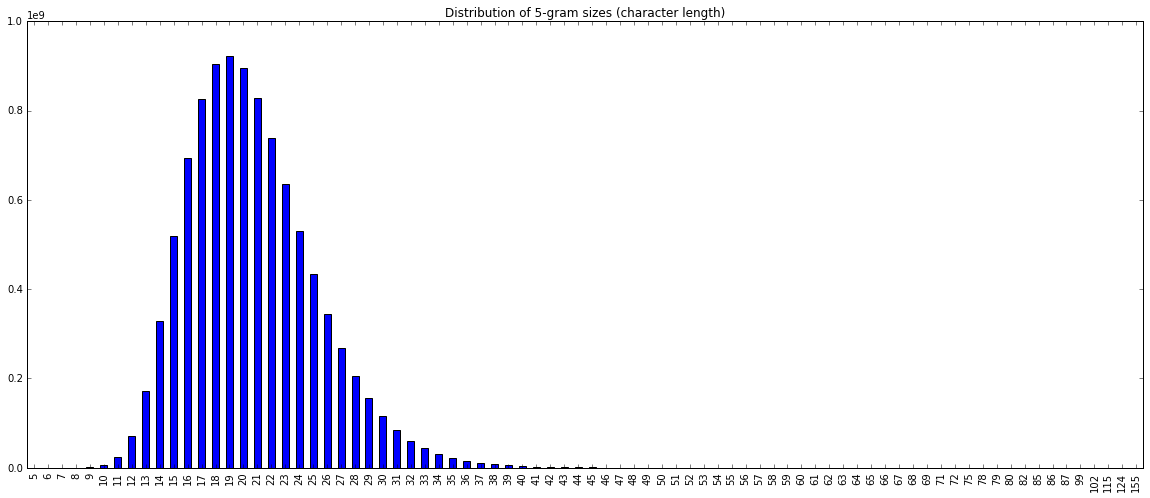

In [13]:
##### OUTPUT FOR HW5.3 5-GRAM LENGTH DISTRIBUTIONS #####
%matplotlib inline
import pandas

# Initialize a dictionary to store the lengths and frequencies
len_freq = {}
filename = 'EDALengthCount_results.text'
with open(filename, 'r') as f:
    for line in f.readlines():
        key,value =  line.strip().split('\t',2)
        len_freq[int(key)] = int(value)

#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

# Plot a histogram of the lengths and their frequencies
df = pandas.DataFrame.from_dict(len_freq, orient='index')
df = df.sort_index()
df.plot(kind='bar', figsize=(20,8), legend=False,
        title='Distribution of 5-gram sizes (character length)')

## HW 5.4  Synonym detection over 2Gig of Data

For the remainder of this assignment you will work with two datasets:

### 1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

- DocA {X:20, Y:30, Z:5}
- DocB {X:100, Y:20}
- DocC {M:5, N:20, Z:5}

### 2: A large subset of the Google n-grams dataset as was described above

For each HW 5.4 -5.5.1 Please unit test and system test your code with respect 
to SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations for the 
SYSTEMS TEST DATASET. Then show the results you get with you system.

In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

(1) Build stripes for the most frequent 10,000 words using cooccurence informationa based on
the words ranked from 9001,-10,000 as a basis/vocabulary (drop stopword-like terms),
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).


(2) Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

==Design notes for (1)==
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

==Design notes for (2)==
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 

Please report the size of the cluster used and the amount of time it takes to run for the index construction task and for the synonym calculation task. How many pairs need to be processed (HINT: use the posting list length to calculate directly)? Report your  Cluster configuration!

**ANSWER:**  

**S3 Locations:**  
**stripes:**  **bucket:**  berkeley.mids.w261.hw5, **folder:**  HW5Results, **file:**  stripes_2.txt  
**link:** https://s3-us-west-2.amazonaws.com/berkeley.mids.w261.hw5/HW5Results/stripes_2.txt  

**similarities:**  **bucket:**  berkeley.mids.w261.hw5, **folder:**  HW5Results, **file:**  similarity_sorted.txt  
**link:** https://s3-us-west-2.amazonaws.com/berkeley.mids.w261.hw5/HW5Results/similarity_sorted.txt

**Cluster configuration**  

|  | Description |
| - | - |
| Cloud environment | IBM SoftLayer |
| Master server | 2 CPU, 8GB RAM, 25GB disk, 100GB disk |
| 3 slaves | 2 CPU, 8GB RAM, 25GB disk, 100GB disk |
| 2 slaves | 8 CPU, 16GB RAM, 100GB disk, 100GB disk |
| **TOTAL** | **24 CPU, 64GB RAM, 300GB disk, 600GB disk** |

**Timings**  

| Task | Time |
| - | - |
| Build Inverted Index | 1.5mins |
| Calculate Similarities | 1hr, 24mins |

**Number of Pairs Processed**  
**Actual Number of pairs processed**  
The number of lines in the output from the similarity job was 35,039,156 so 35,039,156 pairs were processed.  
**Actual Number of pairs processed = 35,039,156 (about 35 million)**    

**Theoretical Number of pairs processed** 
Theoretically, the number of pairs that could potentially processed in this problem is as follows:  
Number of pairs processed = (# of rows in the inverted index) * (# of pairs processed per row)  
Number of pairs processed = (1,000) * (10,000 choose 2)  
Number of pairs processed = (1,000) * (10,000! / (2! * 9,998!))  
Number of pairs processed = (1,000) * (10,000 * 9,9999 / 2 )  
Number of pairs processed = (1,000) * (45,995,000)  

Formula used in the above calculation.  Number combinations (order does not matter) of n things taken k at a time without repetition is n! / (k! * (n-k)!).  

**Theoretical Number of pairs processed = 45,995,000,000 (about 46 billion)**   

Because the inverted index is sparse, there are 3 orders of magnitude fewer pairs to process.

**Formulas for Similarity**  
The formulas for cosine and jaccard similarity used in the code below are as follows:  

Cosine similarity between 2 vectors A and B:  (A dot B) / (||A|| * ||B||).

Jaccard similarity between A and B:  |A and B| / (|A| + |B| - |A and B|) 

**STOP WORDS USED**
'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
     'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 
     'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
     'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
     'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'and', 'but', 'if', 'or', 'because', 
     'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
     'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 
     'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
     'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
     'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
     'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', "ain't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", 
     "hasn't", "haven't", "isn't", 'ma', "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't", 
     "weren't", "won't", "wouldn't", "don't", "can't", 'would', 'could', 'might', 'must', 'need'

#### Create Extended Systems Test Data and Load it in to HDFS

In [3]:
%%writefile ext_systems_test_Stripes.txt
"also.3"	{"expected": 20, "years": 30, "size": 5}
"back.2"	{"expected": 100, "years": 20}
"case.4"	{"may": 5, "new": 20, "size": 5, "years": 1}

Overwriting ext_systems_test_Stripes.txt


In [7]:
#!cat ext_systems_test_Stripes.txt
#!hdfs dfs -copyFromLocal ext_systems_test_Stripes.txt /user/hadoop
#!hdfs dfs -ls /user/hadoop

In [1]:
%%writefile Stripes5Gram.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
from collections import Counter
    
# This class outputs stripes for the top 10,000 most frequent words.  In each of the stripes
# are the counts of how many times each feature (the 9,001 to 10,000 most frequent words occur)
# occur.  Symmetry is preserved.
class MRStripes5Gram(MRJob):
    freq_words = set()
    features = set()
    
    # Create sets for storing the frequent words and the features
    def mapper_stripes_init(self):
        self.word_stripe_counts = {}
        with open('5-4words.txt', 'r') as f:
            count = 0
            for line in f.readlines():
                if count < 10000:
                    self.freq_words.add(line.strip())
                else:
                    self.features.add(line.strip())
                count += 1
    
    def mapper_stripes(self, _, line):
        record = line.strip().split('\t')
        words = record[0].lower().split()
        count = int(record[1])
        # loop through all of the words from the line and create
        # a stripe that contains all of the co-occuring words (except itself)
        # and their counts.
        for w1 in words:
            if w1 in self.freq_words:
                H = {}
                for w2 in words:
                    if (w1 != w2) and (w2 in self.features):
                        if w2 in H:
                            H[w2] += count
                        else:
                            H[w2] = count
                if H != {}:
                    yield w1, H

    # sum the values in the stripes for common words
    def combiner_stripes(self, word, counts):
        sum_H = Counter()
        for H in counts:
            sum_H += Counter(H)
        yield word, sum_H

    # sum the values in the stripes for common words
    # also attach the length of the stripe to the key with a period
    # this is the cardinality of that word to be used for 
    # jaccard similarity later.
    def reducer_stripes(self, word, counts):
        sum_H = Counter()
        for H in counts:
            sum_H += Counter(H)
        yield word+'.'+str(len(sum_H)), sum_H
    
    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.reduces': '2'             # Specify 2 reducers
        }
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper_init=self.mapper_stripes_init, mapper=self.mapper_stripes, 
                   combiner=self.combiner_stripes,
                   reducer=self.reducer_stripes)
        ]

if __name__ == '__main__':
    MRStripes5Gram.run()

Overwriting Stripes5Gram.py


In [15]:
# Add required files to HDFS
#!hdfs dfs -rm /user/hadoop/megan_test.txt
#!hdfs dfs -copyFromLocal 'megan_test.txt' /user/hadoop
#!hdfs dfs -rm '5-4words.txt' /user/hadoop
#!hdfs dfs -copyFromLocal '5-4words.txt' /user/hadoop
#!hdfs dfs -mkdir /user/hadoop/HW5Results
#!hdfs dfs -ls

In [4]:
## Local TESTS
#ifile = 'megan_test.txt'
## HDFS TESTS
#ifile = 'hdfs:///user/hadoop/HW5data/'
#ifile = 'hdfs:///user/hadoop/HW5data-test/'
ifile = 'hdfs:///user/hadoop/HW5data-test/googlebooks-eng-all-5gram-20090715-0-filtered_head.txt'
#ifile = 'hdfs:///user/hadoop/megan_test.txt'
ofile = 'outputHW5/Stripes5Gram'
!hdfs dfs -rm -r /user/hadoop/$ofile
#!nohup python Stripes5Gram.py -r hadoop $ifile --output-dir=$ofile --no-output
!python Stripes5Gram.py -r hadoop $ifile --output-dir=$ofile --file='5-4words.txt'

In [2]:
##### OUTPUT FOR HW5.4 STRIPES #####
#!hdfs dfs -cat outputHW5/Stripes5Gram/part-00000 | head -1
#!hdfs dfs -cat outputHW5/Stripes5Gram/part-00001 | head
#!hdfs dfs -cat outputHW5/Stripes5Gram/part-00000 > stripes_2.txt
#!hdfs dfs -cat outputHW5/Stripes5Gram/part-00001 >> stripes_2.txt
#!hdfs dfs -copyFromLocal stripes_2.txt HW5Results
#!hdfs dfs -rm megan_test_Stripes.txt
#!hdfs dfs -cp outputHW5/Stripes5Gram/part-00000 megan_test_Stripes.txt
#!hdfs dfs -cat megan_test_Stripes.txt
#!hdfs dfs -copyToLocal outputHW5/Stripes5Gram/part-00000 megan_test_Stripes.txt

In [3]:
%%writefile InvIndex5Gram.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
from collections import Counter
    
# This class takes stripes as inputs, binarizes them (sets all of the counts of the words
# in the stripe to 1), normalizes them (divides them by the square root of their length)
# and inverts the stripe matrix.
class MRInvIndex5Gram(MRJob):
    word_stripe_counts = {}

    # set all word counts to 1
    def binarize_stripe(self, stripe):
        for w in stripe:
            stripe[w] = 1
        return stripe
    
    # divide all word counts by the square root of their length
    def normalize_stripe(self, stripe):
        length = float(len(stripe))
        for w in stripe:
            stripe[w] /= pow(length, 0.5)
        return stripe
    
    # invert the stripes matrix.
    def mapper_inv_index(self, _, data):
        word, stripe = data.split('\t')
        word = word.strip('"')
        stripe = ast.literal_eval(stripe)
        bin_stripe = self.binarize_stripe(stripe)
        norm_stripe = self.normalize_stripe(bin_stripe)
        for w, value in norm_stripe.iteritems():
            H = {}
            H[word] = value
            yield w, H

    # sum the values in the stripes for common words
    def reducer_inv_index(self, word, counts):
        sum_H = Counter()
        for H in counts:
            sum_H += Counter(H)
        yield word, sum_H
    
    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.reduces': '2'                   # Set number of reducers to 2
        }
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper_inv_index,
                   combiner=self.reducer_inv_index,
                   reducer=self.reducer_inv_index)
        ]

if __name__ == '__main__':
    MRInvIndex5Gram.run()

Overwriting InvIndex5Gram.py


In [8]:
## Local file locations
#ifile = 'systems_test_Stripes.txt'
#ifile = 'megan_test_Stripes.txt'
ifile = 'ext_systems_test_Stripes.txt'
## HDFS file locations
#ifile = 'hdfs:///user/hadoop/systems_test_Stripes.txt'
#ifile = 'hdfs:///user/hadoop/megan_test_Stripes.txt'
#ifile = 'hdfs:///user/hadoop/outputHW5/Stripes5Gram'
ofile = 'outputHW5/InvIndex5Gram'
#!hdfs dfs -rm /user/hadoop/outputHW5/Stripes5Gram/_SUCCESS
#!hdfs dfs -rm -r /user/hadoop/$ofile
#!nohup python InvIndex5Gram.py -r hadoop $ifile --output-dir=$ofile --no-output
!python InvIndex5Gram.py $ifile --output-dir=$ofile

No configs found; falling back on auto-configuration
Running step 1 of 1...
Creating temp directory /tmp/InvIndex5Gram.hadoop.20160617.135658.524173
Streaming final output from outputHW5/InvIndex5Gram...
"years"	{"back.2": 0.7071067811865475, "case.4": 0.5, "also.3": 0.5773502691896258}
"expected"	{"back.2": 0.7071067811865475, "also.3": 0.5773502691896258}
"may"	{"case.4": 0.5}
"new"	{"case.4": 0.5}
"size"	{"case.4": 0.5, "also.3": 0.5773502691896258}
Removing temp directory /tmp/InvIndex5Gram.hadoop.20160617.135658.524173...


In [9]:
%%writefile ext_systems_test_InvIndex.txt
"years"	{"back.2": 0.7071067811865475, "case.4": 0.5, "also.3": 0.5773502691896258}
"expected"	{"back.2": 0.7071067811865475, "also.3": 0.5773502691896258}
"may"	{"case.4": 0.5}
"new"	{"case.4": 0.5}
"size"	{"case.4": 0.5, "also.3": 0.5773502691896258}

Writing ext_systems_test_InvIndex.txt


In [12]:
## Load the test case in to HDFS
#!cat ext_systems_test_InvIndex.txt
#!hdfs dfs -copyFromLocal ext_systems_test_InvIndex.txt /user/hadoop
#!hdfs dfs -ls /user/hadoop

In [5]:
##### OUTPUT FOR HW5.4 INVERTED INDEX #####
#!hdfs dfs -rm 'systems_test_Stripes.txt'
#!hdfs dfs -rm 'megan_test_Stripes.txt'
#!hdfs dfs -copyFromLocal 'systems_test_Stripes.txt' /user/hadoop
#!hdfs dfs -copyFromLocal 'megan_test_Stripes.txt' /user/hadoop
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00000 | tail -1
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00001 | tail -1
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00000 > inverted_index_2.txt
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00001 >> inverted_index_2.txt
#!hdfs dfs -copyFromLocal inverted_index_2.txt HW5Results
#!hdfs dfs -rm outputHW5/InvIndex5Gram/_SUCCESS
#!hdfs dfs -ls outputHW5/InvIndex5Gram
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00000 | head -20
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00000 | wc -l
#!hdfs dfs -cat outputHW5/InvIndex5Gram/part-00000 | tail -20
#!hdfs dfs -cp outputHW5/InvIndex5Gram/part-00000 HW5Results/inverted_index_full.txt
#!hdfs dfs -cp outputHW5/InvIndex5Gram/part-00000 megan_test_InvIndex.txt
#!hdfs dfs -rm megan_test_InvIndex.txt
#!hdfs dfs -cp outputHW5/InvIndex5Gram/part-00000 megan_test_InvIndex.txt
#!hdfs dfs -cp megan_test_InvIndex.txt HW5Results/megan_test_InvIndex.txt
#!hdfs dfs -copyToLocal systems_test_InvIndex.txt
#!hdfs dfs -copyToLocal megan_test_InvIndex.txt
#!hdfs dfs -cat systems_test_InvIndex.txt

In [11]:
%%writefile Similarity5Gram.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import Counter
import ast
    
# This class calculates the cosine similarity and the jaccard similarity from
# an inverted index
class MRSimilarity5Gram(MRJob):
    def mapper_similarity(self, _, data):
        word, stripe = data.split('\t')
        word = word.strip('"')
        stripe = ast.literal_eval(stripe)
        # If there is only 1 word in the stripe, this will be []
        keys1 = stripe.keys()[:-1]
        # Loop through all of the keys except the last one
        for i, w1 in enumerate(keys1):
            # Loop through all of the keys following w1 in the stripe
            keys2 = stripe.keys()[i+1:]
            for w2 in keys2:
                # Calculate the dot product for cosine similarity
                cosine = stripe[w1]*stripe[w2]
                # Yield the dot product and a count of 1 for jaccard similarity
                yield (w1,w2), (cosine,1)

    # Sum the values for cosine and jaccard similarities for each key
    def combiner_similarity(self, word, data):
        cosine = 0
        jaccard = 0
        for d in data:
            cosine += d[0]
            jaccard += d[1]
        yield word, (cosine,jaccard)
    
    # Sum the values for cosine and jaccard similarities for each key
    # Calculate the jaccard similarity using the formula |w1 and w2| / |w1| + |w2| - |w1 and w2|
    def reducer_similarity(self, word, data):
        w1, c1 = word[0].split('.')
        w2, c2 = word[1].split('.')
        cosine = 0
        jac_and = 0
        for d in data:
            cosine += d[0]
            jac_and += d[1]
        jaccard = jac_and / float(int(c1) + int(c2) - jac_and)
        yield ('%s.%s.%s' % (w1,w2,'C')), cosine
        yield ('%s.%s.%s' % (w1,w2,'J')), jaccard
    
    def steps(self):
        JOBCONF_STEP1 = {        
            'mapreduce.job.maps': '20',
            'mapreduce.job.reduces': '10'
        }
        return [
            MRStep(jobconf=JOBCONF_STEP1,             # STEP 1:  calculate the similarity
                   mapper=self.mapper_similarity,  
                   combiner=self.combiner_similarity,
                   reducer=self.reducer_similarity)
        ]

if __name__ == '__main__':
    MRSimilarity5Gram.run()

Overwriting Similarity5Gram.py


In [3]:
## Local file locations
#ifile = 'megan_test_InvIndex.txt'
#ifile = 'systems_test_InvIndex.txt'
#ifile = 'ext_systems_test_InvIndex.txt'
## HDFS file locations
#ifile = 'hdfs:///user/hadoop/HW5data/'
#ifile = 'hdfs:///user/hadoop/megan_test_InvIndex.txt'
#ifile = 'hdfs:///user/hadoop/systems_test_InvIndex.txt'
ifile = 'hdfs:///user/hadoop/ext_systems_test_InvIndex.txt'
#ifile = 'hdfs:///user/hadoop/outputHW5/InvIndex5Gram'
ofile = 'outputHW5/Similarity5Gram'
#!hdfs dfs -rm /user/hadoop/outputHW5/InvIndex5Gram/_SUCCESS
!hdfs dfs -rm -r /user/hadoop/$ofile
#!nohup python Similarity5Gram.py -r hadoop $ifile --output-dir=$ofile --no-output
!python Similarity5Gram.py -r hadoop $ifile --output-dir=$ofile

In [9]:
##### OUTPUT FOR HW5.4 SIMILARITY CALCULATION #####
### Inspect and aggregate the results ###
#!hdfs dfs -ls outputHW5/Similarity5Gram
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00009 | tail -5
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00000 > similarity_unsorted.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00001 >> similarity_unsorted.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00002 >> similarity_unsorted.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00003 >> similarity_unsorted.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00004 >> similarity_unsorted.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00005 >> similarity_unsorted.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00006 >> similarity_unsorted.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00007 >> similarity_unsorted.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00008 >> similarity_unsorted.txt
#!hdfs dfs -cat outputHW5/Similarity5Gram/part-00009 >> similarity_unsorted.txt
#!hdfs dfs -copyFromLocal similarity_unsorted.txt HW5Results

16/06/17 16:46:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
%%writefile Similarity5GramSort.py
from mrjob.job import MRJob
from mrjob.protocol import RawProtocol
from mrjob.step import MRStep
    
# This class sorts the similarities
class MRSimilarity5GramSort(MRJob):
    MRJob.SORT_VALUES = True 
    INTERNAL_PROTOCOL = RawProtocol
    OUTPUT_PROTOCOL = RawProtocol

    #yield coming from the previous job: ('%s.%s.%s' % (w1,w2,'J')), jaccard
    # Read in the values from the previous job and add a label of 'a' to 'e'
    # depending on the value stored in the input
    def mapper_sort(self, _, data):
        word, value = data.split('\t')
        word = word.strip('"')
        value = float(value)
        if value < 0.2:
            label = 'a'
        elif value < 0.4:
            label = 'b'
        elif value < 0.6:
            label = 'c'
        elif value < 0.8:
            label = 'd'
        else:
            label = 'e'
        yield label, str(value)+'\t'+str(word)
    
    # Output what is received.  The values are sorted at this point.
    def reducer_sort(self, label, value_pair):
        for vp in value_pair:
            v, w = vp.split('\t')
            yield w, v
    
    # Tell the Hadoop shuffle to partition based on the label (a-e) and sort on the 2nd
    # field in reverse order.
    def steps(self):
        JOBCONF_STEP = {        
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapred.lib.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr',
            'mapreduce.job.reduces': '5'
        }
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper_sort,
                   reducer=self.reducer_sort)        
        ]

if __name__ == '__main__':
    MRSimilarity5GramSort.run()

Overwriting Similarity5GramSort.py


In [2]:
# Local file locations
#ifile = 'ext_systems_test_Similarity.txt'
## HDFS file locations
#ifile = 'hdfs:///user/hadoop/megan_test_Similarity.txt'
#ifile = 'hdfs:///user/hadoop/ext_systems_test_Similarity.txt'
ifile = 'hdfs:///user/hadoop/HW5Results/similarity_unsorted.txt'
ofile = 'outputHW5/Similarity5GramSort'
!hdfs dfs -rm -r /user/hadoop/$ofile
#!nohup python Similarity5GramSort.py -r hadoop $ifile --output-dir=$ofile --no-output
!python Similarity5GramSort.py -r hadoop $ifile --output-dir=$ofile

In [1]:
##### OUTPUT FOR HW5.4 SIMILARITY CALCULATION SORT #####
#!hdfs dfs -ls outputHW5/Similarity5GramSort
#!hdfs dfs -cat outputHW5/Similarity5GramSort/part-00000 | head -2
#!hdfs dfs -cat outputHW5/Similarity5GramSort/part-00001 | head -2
#!hdfs dfs -cat outputHW5/Similarity5GramSort/part-00002 | head -2
#!hdfs dfs -cat outputHW5/Similarity5GramSort/part-00003 | head -2
#!hdfs dfs -cat outputHW5/Similarity5GramSort/part-00004 | head -2
#!hdfs dfs -cat outputHW5/Similarity5GramSort/part-00001 > similarity_sorted.txt
#!hdfs dfs -cat outputHW5/Similarity5GramSort/part-00000 >> similarity_sorted.txt
#!hdfs dfs -cat outputHW5/Similarity5GramSort/part-00004 >> similarity_sorted.txt
#!hdfs dfs -cat outputHW5/Similarity5GramSort/part-00003 >> similarity_sorted.txt
#!hdfs dfs -cat outputHW5/Similarity5GramSort/part-00002 >> similarity_sorted.txt
#!hdfs dfs -copyFromLocal similarity_sorted.txt HW5Results

#!hdfs dfs -cat HW5Results/similarity_sorted.txt | head -2000 | grep '.C' | head -1000 > similarity_cos_top1000.txt 
#!hdfs dfs -cat HW5Results/similarity_sorted.txt | head -10 | grep '.C"'

## HW 5.5 Evaluation of synonyms that your discovered
In this part of the assignment you will evaluate the success of you synonym detector (developed in response to HW5.4).
Take the top 1,000 closest/most similar/correlative pairs of words as determined by your measure in HW5.4, and use the synonyms function in the accompanying python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.

**ANSWER:**  

TP = true positive, FP = false positive, FN = false negative  
Precision (P) = TP / (TP + FP), uses false positives  
Recall (R) = TP / (TP + FN), uses false negatives  
F1 = 2 x (precision x recall) / (precision + recall)  

**Hits:** 15/1,000  
**Precision:** 0.015000  
**Recall:** 1.000000  
**F1 Score:** 0.029557

TP = the number of hits found by nltk in the top 1,000
FP = the number of non-hits found by nltk in the top 1,000
FN = 0, there are no false negatives found by nltk in the top 1,000

In [60]:
import nltk_synonyms as nltk

# Calculate how many synonyms are found in the input file using the nltk library.
filename = 'similarity_cos_top1000.txt'
with open(filename, 'r') as f:
    total_count = 0
    total_correct = 0
    for line in f.readlines():
        w1,w2,_ = line.strip().split('\t')[0].strip('"').split('.')
        # If a one of the pair of words is in the synonym list of the other, then
        # mark it a 'hit' and increase the total_correct
        if (w1 in nltk.synonyms(w2)) or (w2 in nltk.synonyms(w1)):
            total_correct += 1
            print w1, w2
        total_count += 1
    # Calculate precision, recall and F1 score according to the formulas above
    TP = total_correct
    FP = total_count - total_correct # total incorrect
    FN = 0
    precision = TP / float(TP + FP)
    recall = TP / float(TP + FN)
    F1 = 2 * (precision * recall) / (precision + recall)
    print
    print('Hits: %d/%d, Precision: %f, Recall: %f, F1 Score: %f' % (total_correct, total_count, precision, recall, F1))

make made
means way
well good
take made
men man
work made
place order
world man
make form
found see
men world
state states
still yet
best well
form made
Hits: 15/1000, Precision: 0.015000, Recall: 1.000000, F1 Score: 0.029557


### Get Google N-Gram Data

In [12]:
%%writefile get_5gram_data.sh
#!/bin/bash

for index in {0..189}
do
  wget http://filtered-5grams.s3.amazonaws.com/googlebooks-eng-all-5gram-20090715-${index}-filtered.txt
done

Writing get_5gram_data.sh


In [13]:
!chmod +x get_5gram_data.sh

In [15]:
#!./get_5gram_data.sh

In [1]:
# Load the 5-gram data in to HDFS
#!hdfs dfs -mkdir /user/hadoop/HW5data
#!hdfs dfs -rm /user/hadoop/HW5data/googlebooks-eng-all-5gram-20090715-65-filtered.txt
for i in range(65,190):
    filename = 'data/googlebooks-eng-all-5gram-20090715-' + str(i) + '-filtered.txt'
    !hdfs dfs -copyFromLocal $filename /user/hadoop/HW5data
# List the files in the HW5data directory to ensure that they are all in there
!hdfs dfs -ls /user/hadoop/HW5data

### Create file of Words and Values for 5.4

In [2]:
### STOP WORDS USED ###
w = ['the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 
     'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 
     'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 
     'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 
     'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'and', 'but', 'if', 'or', 'because', 
     'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 
     'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 
     'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 
     'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 
     'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 
     'should', 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', "ain't", "aren't", "couldn't", "didn't", "doesn't", "hadn't", 
     "hasn't", "haven't", "isn't", 'ma', "mightn't", "mustn't", "needn't", "shan't", "shouldn't", "wasn't", 
     "weren't", "won't", "wouldn't", "don't", "can't", 'would', 'could', 'might', 'must', 'need']

def remove_stop_words(f1, f2, w, n):
    with open(f1, 'r') as ifile, open(f2, 'w+') as ofile:
        i = 0
        count = 0
        word_count = 0
        for line in ifile.readlines():
            if word_count < n:
                word = line.split()[0].strip('"')
                if word in w:
                    #print i, word
                    count += 1
                else:
                    ofile.write(word+'\n')
                    word_count += 1
                i += 1
            else:
                break
        print(count)

remove_stop_words('5-4words_full.txt', '5-4words.txt', w, 10000)

139
